## Материалы
https://github.com/esokolov/ml-course-hse -- лекции Соколова, 2016-fall лекции 4 и 5 про линейные классификаторы и логистическую регрессию.
https://habr.com/en/company/ods/blog/323890/#2-logisticheskaya-regressiya -- открытый курс машинного обучения

https://yandexdataschool.ru/edu-process/courses/machine-learning -- лекции Воронцова

# Решение задачи бинарной классификации на примере даных о сахарном диабете у женщин индейского племени Пима.

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

In [6]:
# https://www.kaggle.com/mehdidag/pima-indians
data = pd.read_csv("PimaIndians.csv")
data = data.replace({'test': {'negatif': False, 'positif': True}})

Xold = data.drop("test", axis=1)
from sklearn import preprocessing
X = preprocessing.scale(Xold)
Y = data['test']

data.head()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  import sys


,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
0,1,89,66,23,94,28.1,0.167,21,False
1,0,137,40,35,168,43.1,2.288,33,True
2,3,78,50,32,88,31.0,0.248,26,True
3,2,197,70,45,543,30.5,0.158,53,True
4,1,189,60,23,846,30.1,0.398,59,True


diastolic - the blood pressure,
diabetes - it is an indicator of history of diabetes in the family,
test - the patient shows signs of diabetes.
Все признаки являются порядковыми.

В данных нет пропущенных значений:

In [3]:
data.columns[data.isnull().values.any()].tolist()

[]

### Посмотрим матрицу коррелляций признаков между собой и с целевой переменной.

In [4]:
data.corr()

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
pregnant,1.000000,0.198291,0.213355,0.093209,0.078984,-0.025347,0.007562,0.679608,0.256566
glucose,0.198291,1.000000,0.210027,0.198856,0.581223,0.209516,0.140180,0.343641,0.515703
diastolic,0.213355,0.210027,1.000000,0.232571,0.098512,0.304403,-0.015971,0.300039,0.192673
triceps,0.093209,0.198856,0.232571,1.000000,0.182199,0.664355,0.160499,0.167761,0.255936
insulin,0.078984,0.581223,0.098512,0.182199,1.000000,0.226397,0.135906,0.217082,0.301429
bmi,-0.025347,0.209516,0.304403,0.664355,0.226397,1.000000,0.158771,0.069814,0.270118
diabetes,0.007562,0.140180,-0.015971,0.160499,0.135906,0.158771,1.000000,0.085029,0.209330
age,0.679608,0.343641,0.300039,0.167761,0.217082,0.069814,0.085029,1.000000,0.350804
test,0.256566,0.515703,0.192673,0.255936,0.301429,0.270118,0.209330,0.350804,1.000000


Как видно, уровень сахара в крови больше всего коррелирует с диабетом, что не удивительно.

Для визуализации корреляционной матрицы будем использовать "тепловую карту" heatmap которая показывает степень корреляции различными цветами:

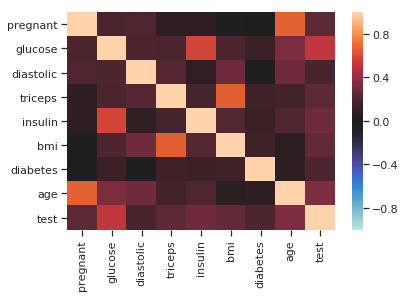

In [5]:
%matplotlib inline 
sns.set(style="ticks")

sns.heatmap(data.corr(), vmin = -1, vmax=1, center = 0)

Корреляционная матрица позволяет понять зависимость между признаками. Не менее важно понять насколько значения целевого признака разделимы в рамках исходных признаков. Для ответа на этот вопрос используется матрица рассеяния (scatter matrix). По диагонали матрицы выводятся гистограммы распределения признаков, другие элементы матрицы показывают гистограмму рассеяния (при этом точки относящиеся к различным значениям целевого признака выделяются разными цветами).

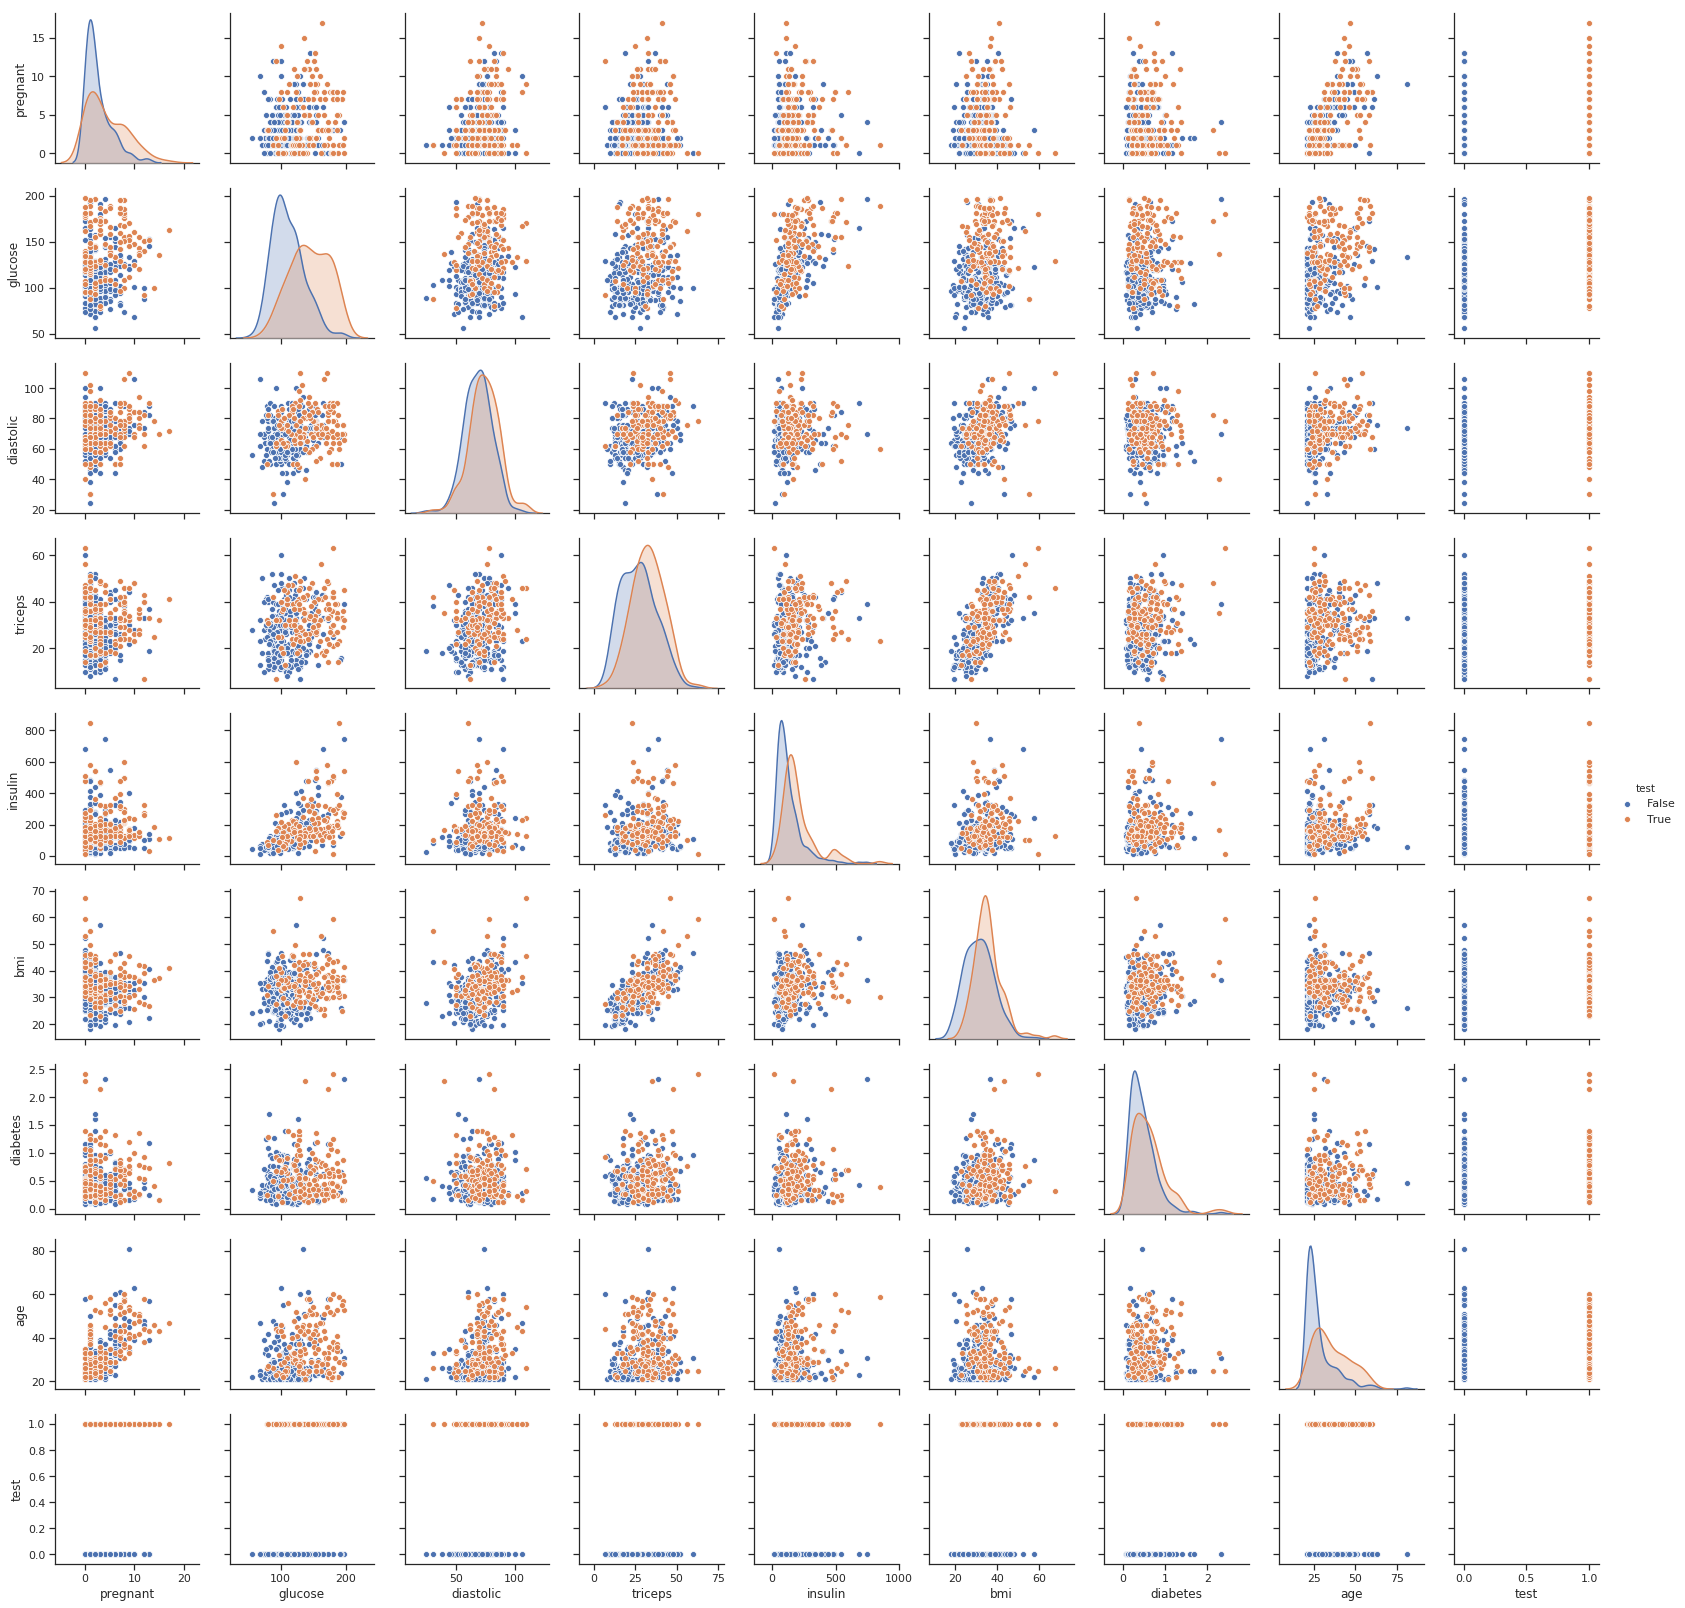

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
np.seterr(invalid='ignore')

sns.pairplot(data, hue="test")

### Определим баланс классов

 Посмотрим какое количество нулей и единиц содержит обучающая выборка. Это позволит нам определиться с метрикой точности.

In [7]:
print("Количество нулей={}, а количество единиц={}".format(*np.bincount(Y)))

Количество нулей=262, а количество единиц=130


In [8]:
# вспомогательные массивы для построения графика
arr_name = []
arr_train = []
arr_test = []

### Разделим выборку на группы кроссвалидации для подгонки параметров и для подсчета качества модели

In [52]:
from sklearn.metrics import roc_auc_score
# разбиение для подгонки параметров
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(6, shuffle = True, random_state=1)
#loo = StratifiedKFold(12, shuffle = True, random_state=1)
# делаем кроссвалидацию при выбранных параметрах и считаем roc-auc
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
def roc_auc_cv(mod, X=X):
    Ycv = np.empty(len(X))
    cvs = cross_val_score(mod, X, Y, cv = loo, scoring='accuracy')
    Ycv[cvs == 1] = Y[cvs == 1]
    Ycv[cvs == 0] = 1 - Y[cvs == 0]
    return(roc_auc_score(Y,Ycv))

## Проецирование на главные компоненты

In [7]:
from sklearn.decomposition import PCA
pca = PCA()
Xpca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.31994031 0.19459756 0.14984544 0.11946188 0.09002175 0.05017765
 0.03888422 0.03707119]


#### Координаты первых 3 ГК

In [14]:
print(pd.DataFrame(pca.components_[range(3)], columns = Xold.columns))

   pregnant   glucose  diastolic   triceps   insulin       bmi  diabetes  \
0  0.314590  0.424332   0.329577  0.382848  0.364886  0.367752  0.167371   
1 -0.551916 -0.046912  -0.031026  0.412884  0.067720  0.504639  0.188264   
2 -0.218493  0.473895  -0.390719 -0.302433  0.581842 -0.256405  0.255610   

        age  
0  0.411565  
1 -0.476510  
2 -0.118060  


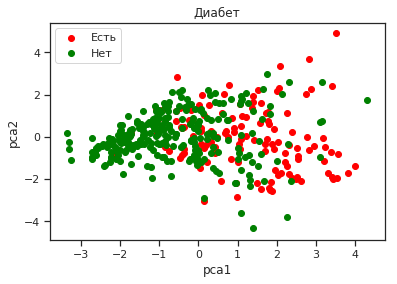

In [11]:
plt.scatter(Xpca[Y == 1, 0], Xpca[Y == 1, 1], c='red', label='Есть')
plt.scatter(Xpca[Y == 0, 0], Xpca[Y == 0, 1], c='green', label='Нет')
plt.xlabel("pca1")
plt.ylabel("pca2")
plt.title('Диабет')
plt.legend();

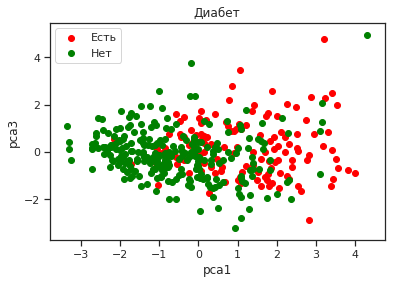

In [12]:
plt.scatter(Xpca[Y == 1, 0], Xpca[Y == 1, 2], c='red', label='Есть')
plt.scatter(Xpca[Y == 0, 0], Xpca[Y == 0, 2], c='green', label='Нет')
plt.xlabel("pca1")
plt.ylabel("pca3")
plt.title('Диабет')
plt.legend();

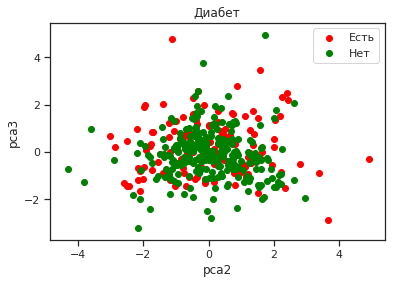

In [13]:
plt.scatter(Xpca[Y == 1, 1], Xpca[Y == 1, 2], c='red', label='Есть')
plt.scatter(Xpca[Y == 0, 1], Xpca[Y == 0, 2], c='green', label='Нет')
plt.xlabel("pca2")
plt.ylabel("pca3")
plt.title('Диабет')
plt.legend();

# Алгоритмы бинарной классификации

## Логистическая регрессия

In [14]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=1e5, random_state=1, class_weight = 'balanced')
logit.fit(X, Y)

logit_tt = {'train': np.round(roc_auc_score(Y,logit.predict(X)), 3), 
          'test': np.round(roc_auc_cv(logit), 3)}
print(logit_tt)

#arr_name.append('LR')
#arr_train.append(logit_tt['train'])
#arr_test.append(logit_tt['test'])

{'train': 0.776, 'test': 0.757}


### Lasso

{'C': 0.15} {'train': 0.78, 'test': 0.764}
      pregnant   glucose  diastolic   triceps  insulin       bmi  diabetes  \
coef   0.15772  1.005781        0.0  0.071331      0.0  0.407322  0.308338   

           age  
coef  0.346502  


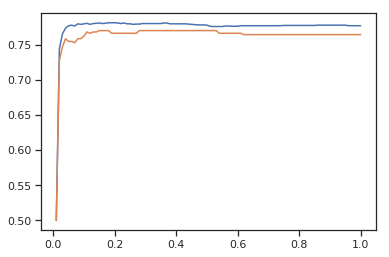

In [104]:
lr1 = LogisticRegression(random_state = 1, class_weight = 'balanced', penalty='l1', solver='saga')
c_values = [i/100 for i in range(1,101)]
lr1_params={'C': c_values}
lr1_clf = GridSearchCV(lr1, lr1_params, cv=kf, scoring = 'balanced_accuracy')
lr1_clf.fit(X, Y)

lr1_tt = {'train': np.round(roc_auc_score(Y,lr1_clf.predict(X)), 3), 
          'test': np.round(roc_auc_cv(lr1_clf.best_estimator_), 3)}
print(lr1_clf.best_params_, lr1_tt)

print(pd.DataFrame(lr1_clf.best_estimator_.coef_, columns = Xold.columns, index=['coef']))

x = c_values
plt.plot(x, lr1_clf.cv_results_['mean_train_score'])
plt.plot(x, lr1_clf.cv_results_['mean_test_score'])
plt.show()

arr_name.append('LR_l1')
arr_train.append(lr1_tt['train'])
arr_test.append(lr1_tt['test'])

### Ridge

{'C': 0.02} {'train': 0.774, 'test': 0.774}
      pregnant   glucose  diastolic   triceps  insulin       bmi  diabetes  \
coef   0.15772  1.005781        0.0  0.071331      0.0  0.407322  0.308338   

           age  
coef  0.346502  


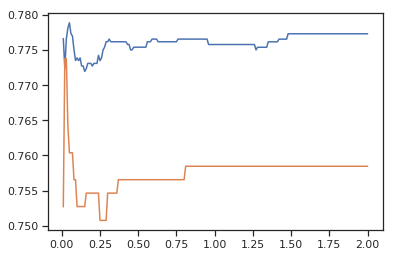

In [105]:
lr2 = LogisticRegression(random_state = 1, class_weight = 'balanced', penalty='l2')
c_values = [i/100 for i in range(1,201)]
lr2_params={'C': c_values}
lr2_clf = GridSearchCV(lr2, lr2_params, cv=kf, scoring = 'balanced_accuracy')
lr2_clf.fit(X, Y)

lr2_tt = {'train': np.round(roc_auc_score(Y,lr2_clf.predict(X)), 3), 
          'test': np.round(roc_auc_cv(lr2_clf.best_estimator_), 3)}
print(lr2_clf.best_params_, lr2_tt)

print(pd.DataFrame(lr2_clf.best_estimator_.coef_, columns = Xold.columns, index=['coef']))

x = c_values
plt.plot(x, lr2_clf.cv_results_['mean_train_score'])
plt.plot(x, lr2_clf.cv_results_['mean_test_score'])
plt.show()

arr_name.append('LR_l2')
arr_train.append(lr2_tt['train'])
arr_test.append(lr2_tt['test'])

{'C': 0.23} {'train': 0.816, 'test': 0.766}


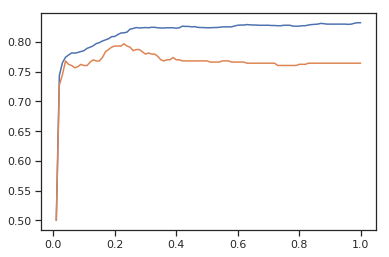

In [17]:
poly = PolynomialFeatures(degree=2)
Xp = preprocessing.scale(poly.fit_transform(X))
lr1p = LogisticRegression(random_state = 1, class_weight = 'balanced', penalty='l1', solver='saga', max_iter=1000)
c_values = [i/100 for i in range(1,101)]
lr1p_params={'C': c_values}
lr1p_clf = GridSearchCV(lr1p, lr1p_params, cv=kf, scoring = 'balanced_accuracy')
lr1p_clf.fit(Xp, Y)

lr1p_tt = {'train': np.round(roc_auc_score(Y,lr1p_clf.predict(Xp)), 3), 
          'test': np.round(roc_auc_cv(lr1p_clf.best_estimator_), 3)}
print(lr1p_clf.best_params_, lr1p_tt)

x = c_values
plt.plot(x, lr1p_clf.cv_results_['mean_train_score'])
plt.plot(x, lr1p_clf.cv_results_['mean_test_score'])
plt.show()

#arr_name.append('LR_l1')
#arr_train.append(lr1_tt['train'])
#arr_test.append(lr1_tt['test'])

{'C': 0.02} {'train': 0.803, 'test': 0.759}


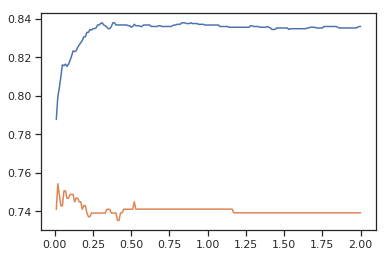

In [18]:
lr2p = LogisticRegression(random_state = 1, class_weight = 'balanced', penalty='l2')
c_values = [i/100 for i in range(1,201)]
lr2p_params={'C': c_values}
lr2p_clf = GridSearchCV(lr2p, lr2p_params, cv=kf, scoring = 'balanced_accuracy')
lr2p_clf.fit(Xp, Y)

lr2p_tt = {'train': np.round(roc_auc_score(Y,lr2p_clf.predict(Xp)), 3), 
          'test': np.round(roc_auc_cv(lr2p_clf.best_estimator_, Xp), 3)}
print(lr2p_clf.best_params_, lr2p_tt)

x = c_values
plt.plot(x, lr2p_clf.cv_results_['mean_train_score'])
plt.plot(x, lr2p_clf.cv_results_['mean_test_score'])
plt.show()

#arr_name.append('LR_l2_polynomial')
#arr_train.append(lr2p_tt['train'])
#arr_test.append(lr2p_tt['test'])

# Дискриминантный анализ

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
da_clf = LinearDiscriminantAnalysis()
da_clf.fit(X, Y)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [20]:
arr_name.append('LDA')
arr_train.append(roc_auc_score(Y,da_clf.predict(X)))
arr_test.append(roc_auc_cv(da_clf))
print(arr_name, arr_train, arr_test)

['LR_l1', 'LR_l2', 'LDA'] [0.78, 0.774, 0.7350557839107459] [0.764, 0.774, 0.7312096300645918]


shrinkage - Shrinkage is a tool to improve estimation of covariance matrices in situations where the number of training samples is small compared to the number of features.

## Метод опорных векторов

In [21]:
from sklearn.svm import SVC
svc = SVC(gamma="auto")
parameters = {
    'kernel': ['poly'],#['linear', 'rbf', 'poly'], 
    'C': [3],#[1,2,3,4,5,6], 
    'degree': [1]}#[1,2,3,4,5,6]}
svc_clf = GridSearchCV(svc, parameters, cv=kf, scoring = 'balanced_accuracy')
svc_clf.fit(X,Y)
print(svc_clf.best_params_)

{'C': 3, 'degree': 1, 'kernel': 'poly'}


In [22]:
arr_name.append('SVM')
arr_train.append(roc_auc_score(Y,svc_clf.predict(X)))
arr_test.append(roc_auc_cv(svc_clf.best_estimator_))
print(arr_name, arr_train, arr_test)

['LR_l1', 'LR_l2', 'LDA', 'SVM'] [0.78, 0.774, 0.7350557839107459, 0.727363476218438] [0.764, 0.774, 0.7312096300645918, 0.7196711685261304]


gamma=Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

Current default is ‘auto’ which uses 1 / n_features, if gamma='scale' is passed then it uses 1 / (n_features * X.std()) as value of gamma. The current default of gamma, ‘auto’, will change to ‘scale’ in version 0.22. ‘auto_deprecated’, a deprecated version of ‘auto’ is used as a default indicating that no explicit value of gamma was passed.

## Дерево решений

In [23]:
from sklearn.tree import DecisionTreeClassifier

dt=DecisionTreeClassifier(random_state=1, class_weight = 'balanced')
dt_params={'criterion': ['entropy'], #['gini', 'entropy'], 
           'max_depth': [7], #range(3,12,2),
           #'min_samples_split': range(2,10,2), # мин к-во элем в листе для деления
           'min_samples_leaf': [8], #range(4,19,2), #, # мин к-во элем в листе
           'max_features': [6], #range(3,9), # сколько признаков юзать
           'max_leaf_nodes': [15], #range(11,19,2), # макс к-во листьев
           'min_impurity_decrease': [.0], #[x/1000 for x in range(0,21,4)]
                # критерий останова увеличения информативности
          }
dt_clf = GridSearchCV(dt, dt_params, cv=kf, scoring = 'balanced_accuracy')
dt_clf.fit(X, Y)

dt_tt = {'train': np.round(roc_auc_score(Y,dt_clf.predict(X)), 3), 
          'test': np.round(roc_auc_cv(dt_clf.best_estimator_), 3)}
print(dt_clf.best_params_, dt_tt)

{'criterion': 'entropy', 'max_depth': 7, 'max_features': 6, 'max_leaf_nodes': 15, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8} {'train': 0.832, 'test': 0.765}


In [24]:
arr_name.append('Simple_tree')
arr_train.append(dt_tt['train'])
arr_test.append(dt_tt['test'])
print(arr_name, arr_train, arr_test)

['LR_l1', 'LR_l2', 'LDA', 'SVM', 'Simple_tree'] [0.78, 0.774, 0.7350557839107459, 0.727363476218438, 0.832] [0.764, 0.774, 0.7312096300645918, 0.7196711685261304, 0.765]


#### Попробуем обучить на главных компонентах

#### Доли объясненной дисперсии

In [25]:
print(pca.explained_variance_ratio_)

[0.31994031 0.19459756 0.14984544 0.11946188 0.09002175 0.05017765
 0.03888422 0.03707119]


In [26]:
dt=DecisionTreeClassifier(random_state=1, class_weight = 'balanced')
dt_params={'criterion': ['entropy'], #['gini', 'entropy'], 
           'max_depth': [5], #range(3,8,2),
           #'min_samples_split': range(2,13,2), # мин к-во элем в листе для деления
           'min_samples_leaf': [10], #range(6,15,2), #, # мин к-во элем в листе
           'max_features': [3], #range(2,9), # сколько признаков юзать
           'max_leaf_nodes': [16], #range(12,23,2), # макс к-во листьев
           'min_impurity_decrease': [0.004] #[x/1000 for x in range(0,21,4)]
                # критерий останова увеличения информативности
          }
dt_clf = GridSearchCV(dt, dt_params, cv=kf, scoring = 'balanced_accuracy')
dt_clf.fit(Xpca, Y)

dt_tt = {'train': np.round(roc_auc_score(Y,dt_clf.predict(Xpca)), 3), 
          'test': np.round(roc_auc_cv(dt_clf.best_estimator_, Xpca), 3)}
print(dt_clf.best_params_, dt_tt)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 3, 'max_leaf_nodes': 16, 'min_impurity_decrease': 0.004, 'min_samples_leaf': 10} {'train': 0.812, 'test': 0.743}


In [27]:
arr_name.append('Simple_tree on PCA')
arr_train.append(dt_tt['train'])
arr_test.append(dt_tt['test'])
print(arr_name, arr_train, arr_test)

['LR_l1', 'LR_l2', 'LDA', 'SVM', 'Simple_tree', 'Simple_tree on PCA'] [0.78, 0.774, 0.7350557839107459, 0.727363476218438, 0.832, 0.812] [0.764, 0.774, 0.7312096300645918, 0.7196711685261304, 0.765, 0.743]


## Случайный лес

In [63]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(random_state=1, class_weight = 'balanced')
rf_params = {'n_estimators': range(70, 111, 5),
             'criterion': ['entropy'], #['gini', 'entropy'], 
             'max_depth': [3], #range(2,5),
             #'min_samples_leaf': range(6,13,3), #, # мин к-во элем в листе
             'max_features': [3], #range(1,5), # сколько признаков юзать
             'max_leaf_nodes': range(5,14,2), # макс к-во листьев
             'min_impurity_decrease': [x/1000 for x in range(0,26,5)]
                # критерий останова увеличения информативности
            }
rf_clf = GridSearchCV(rf, rf_params, cv=kf, scoring = 'balanced_accuracy')
rf_clf.fit(X,Y)

rf_tt = {'train': np.round(roc_auc_score(Y,rf_clf.predict(X)), 3), 
          'test': np.round(roc_auc_cv(rf_clf.best_estimator_), 3)}
print(rf_clf.best_params_, rf_tt)

{'criterion': 'entropy', 'max_depth': 3, 'max_features': 3, 'max_leaf_nodes': 11, 'min_impurity_decrease': 0.02, 'n_estimators': 105} {'train': 0.86, 'test': 0.776}


#### Вклады признаков

In [100]:
pd.DataFrame(rf_clf.best_estimator_.feature_importances_, index = Xold.columns,
             columns=['importance']).sort_values('importance',  ascending=False)

,importance
glucose,0.354404
age,0.176533
insulin,0.171815
bmi,0.097694
diabetes,0.079753
triceps,0.058168
pregnant,0.037111
diastolic,0.024522


In [75]:
arr_name.append('Random_forest')
arr_train.append(roc_auc_score(Y,rf_clf.predict(X)))
arr_test.append(roc_auc_cv(rf_clf.best_estimator_))
print(arr_name, arr_train, arr_test)

['LR_l1', 'LR_l2', 'LDA', 'SVM', 'Simple_tree', 'Simple_tree on PCA', 'Random_forest'] [0.78, 0.774, 0.7350557839107459, 0.727363476218438, 0.832, 0.812, 0.86] [0.764, 0.774, 0.7312096300645918, 0.7196711685261304, 0.765, 0.743, 0.776]


## Градиентный бустинг (XGBoost)

In [30]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=1, scale_pos_weight=2, nthread=4) 
xgb_params = { 
    'n_estimators' : [70],#range(60, 81, 1), 
    'min_child_weight': [2],#[0.5, 1, 2],  
    'subsample': [.75],#[0.5, 0.75, 1],
    'colsample_bytree': [.5],#[0.5, 0.75, 1],
    'max_depth': [3],#range(2, 8),
    'learning_rate': [.01]#[.01,.05,.1,.2]
}
xgb_clf = GridSearchCV(estimator = xgb, param_grid = xgb_params, scoring = 'balanced_accuracy', cv = kf)
xgb_clf.fit(X,Y)
print(xgb_clf.best_params_)

{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 70, 'subsample': 0.75}


In [31]:
arr_name.append('XGBoost')
arr_train.append(roc_auc_score(Y, xgb_clf.predict(X)))
arr_test.append(roc_auc_cv(xgb_clf.best_estimator_))
print(arr_name, arr_train, arr_test)

['LR_l1', 'LR_l2', 'LDA', 'SVM', 'Simple_tree', 'Simple_tree on PCA', 'Random_forest', 'XGBoost'] [0.78, 0.774, 0.7350557839107459, 0.727363476218438, 0.832, 0.812, 0.8429242513211981, 0.8487668819729889] [0.764, 0.774, 0.7312096300645918, 0.7196711685261304, 0.765, 0.743, 0.748854961832061, 0.7892542571931884]


## Нейронные сети

https://habr.com/company/ods/blog/325432/

In [32]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Input

np.random.seed(1)
loo = StratifiedKFold(12, shuffle = True, random_state=1)

Using TensorFlow backend.


### 2 слоя

In [33]:
def create_model():
    model = Sequential()
    model.add(Dense(12, activation = "relu", input_dim=8))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return(model)

def train_evaluate(model, X, Y, x):
    model.fit(X, Y, verbose=0, epochs = 500, batch_size = 10, validation_split=0.3)
    return(model.predict(x))

In [34]:
YCV = []
NNCV = []
for train, test in loo.split(X, Y):
    YCV = np.concatenate((YCV, Y[test]))
    model = None
    model = create_model()
    NNCV = np.concatenate((NNCV, [round(x[0]) for x in train_evaluate(model, X[train,:], Y[train], X[test,:])]))
model = None
model = create_model()
Ytrain = [round(x[0]) for x in train_evaluate(model, X, Y, X)]

In [35]:
arr_name.append('NN2L')
arr_train.append(roc_auc_score(Y,Ytrain))
arr_test.append(roc_auc_score(YCV, NNCV))
print(arr_name, arr_train, arr_test)

['LR_l1', 'LR_l2', 'LDA', 'SVM', 'Simple_tree', 'Simple_tree on PCA', 'Random_forest', 'XGBoost', 'NN2L'] [0.78, 0.774, 0.7350557839107459, 0.727363476218438, 0.832, 0.812, 0.8429242513211981, 0.8487668819729889, 0.8387844979448033] [0.764, 0.774, 0.7312096300645918, 0.7196711685261304, 0.765, 0.743, 0.748854961832061, 0.7892542571931884, 0.7026130358191427]


### 3 слоя

In [36]:
def create_model():
    model = Sequential()
    model.add(Dense(12, activation = "relu", input_dim=8))
    model.add(Dense(8, activation = "relu"))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return(model)

def train_evaluate(model, X, Y, x):
    model.fit(X, Y, verbose=0, epochs = 500, batch_size = 32, validation_split=0.5)
    return(model.predict(x))

In [37]:
YCV = []
NNCV = []
for train, test in loo.split(X, Y):
    YCV = np.concatenate((YCV, Y[test]))
    model = None
    model = create_model()
    NNCV = np.concatenate((NNCV, [round(x[0]) for x in train_evaluate(model, X[train,:], Y[train], X[test,:])]))
model = None
model = create_model()
Ytrain = [round(x[0]) for x in train_evaluate(model, X, Y, X)]

In [38]:
arr_name.append('NN3L')
arr_train.append(roc_auc_score(Y,Ytrain))
arr_test.append(roc_auc_score(YCV, NNCV))
print(arr_name, arr_train, arr_test)

['LR_l1', 'LR_l2', 'LDA', 'SVM', 'Simple_tree', 'Simple_tree on PCA', 'Random_forest', 'XGBoost', 'NN2L', 'NN3L'] [0.78, 0.774, 0.7350557839107459, 0.727363476218438, 0.832, 0.812, 0.8429242513211981, 0.8487668819729889, 0.8387844979448033, 0.8253669994128009] [0.764, 0.774, 0.7312096300645918, 0.7196711685261304, 0.765, 0.743, 0.748854961832061, 0.7892542571931884, 0.7026130358191427, 0.7333529066353494]


## Сравнение результатов работы алгоритмов

In [119]:
dic={'name':arr_name, 'train': arr_train, 'test': arr_test}
df=round(pd.DataFrame(data=dic), 3)
df.sort_values('test',  ascending=False)

,name,train,test
7,XGB,0.849,0.789
6,RF,0.860,0.776
1,LR_l2,0.774,0.774
4,Tree,0.832,0.765
0,LR_l1,0.780,0.764
5,TreePCA,0.812,0.743
9,NN3L,0.825,0.733
2,LDA,0.735,0.731
3,SVM,0.727,0.720
8,NN2L,0.839,0.703


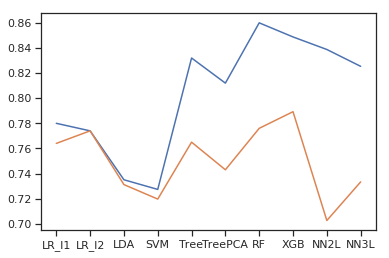

In [117]:
x = range(len(arr_train))
plt.plot(x, arr_train)
plt.plot(x, arr_test)
plt.xticks(x, arr_name)
plt.show()

**Вывод:** наиболее точным на обучающей и валидационной выборках оказался градиентный бустинг.
#### простое дерево не подучилось сделать точнее случайного леса, однако его доверительный интервал равен


In [4]:
print(round(0.765-1.96*(0.765*(1-0.765))**.5/392**.5, 3), round(0.765+1.96*(0.765*(1-0.765))**.5/392**.5, 3))

0.723 0.807
